In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.4.1
2.4.1
cuda


In [2]:
from typing import List

import IPython
import matplotlib.pyplot as plt

In [3]:
from torchaudio.pipelines import MMS_FA as bundle

model = bundle.get_model()
model.to(device)

tokenizer = bundle.get_tokenizer()
aligner = bundle.get_aligner()

In [4]:
def compute_alignments(waveform: torch.Tensor, transcript: List[str]):
    with torch.inference_mode():
        emission, _ = model(waveform.to(device))
        token_spans = aligner(emission[0], tokenizer(transcript))
    return emission, token_spans

In [5]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def plot_alignments(waveform, token_spans, emission, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / emission.size(1) / sample_rate

    fig, axes = plt.subplots(2, 1)
    axes[0].imshow(emission[0].detach().cpu().T, aspect="auto")
    axes[0].set_title("Emission")
    axes[0].set_xticks([])

    axes[1].specgram(waveform[0], Fs=sample_rate)
    for t_spans, chars in zip(token_spans, transcript):
        t0, t1 = t_spans[0].start, t_spans[-1].end
        axes[0].axvspan(t0 - 0.5, t1 - 0.5, facecolor="None", hatch="/", edgecolor="white")
        axes[1].axvspan(ratio * t0, ratio * t1, facecolor="None", hatch="/", edgecolor="white")
        axes[1].annotate(f"{_score(t_spans):.2f}", (ratio * t0, sample_rate * 0.51), annotation_clip=False)

        for span, char in zip(t_spans, chars):
            t0 = span.start * ratio
            axes[1].annotate(char, (t0, sample_rate * 0.55), annotation_clip=False)

    axes[1].set_xlabel("time [second]")
    fig.tight_layout()

In [6]:
def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)

In [7]:
import re


def normalize_uroman(text):
    text = text.lower()
    text = text.replace("’", "'")
    text = re.sub("([^a-z' ])", " ", text)
    text = re.sub(' +', ' ', text)
    return text.strip()


In [13]:
import librosa

from pathlib import Path
from mevgs.utils import read_file

data = [
    "beer_2450_5832_008328",
    "vogel_2450_7759_005808",
    "vogel_2450_6613_002413",
    "boot_2450_5518_000858",
    "auto_1724_11136_000595",
    "kat_2450_8979_001669",
    "klok_2450_4254_000828",
    "klok_2450_7371_000748",
    "koe_2450_5727_003738",
    "koe_2450_3846_005677",
    "koe_1666_1841_002770",
    "hond_2450_3846_003148",
    "hond_2450_4634_000668",
    "olifant_2450_5832_001766",
    "olifant_2450_4029_007837",
    "paard_2450_10646_000169",
]

ROOT = Path("data/mls-dutch-selected")



In [21]:
def align1(datum):
    word, *rest = datum.split("_")
    speaker = rest[0]
    id1 = "_".join(rest)

    path_audio = ROOT / speaker / (id1 + ".opus")
    waveform, sample_rate = librosa.load(path_audio, sr=bundle.sample_rate)

    path_txt = ROOT / speaker / (id1 + ".txt")
    text = read_file(path_txt)
    text_raw = text[0]
    text_normalized = normalize_uroman(text_raw)

    print("Raw Transcript: ", text_raw)
    print("Normalized Transcript: ", text_normalized)
    IPython.display.Audio(waveform, rate=sample_rate)

    transcript = text_normalized.split()
    tokens = tokenizer(transcript)

    waveform = torch.tensor(waveform).unsqueeze(0)
    emission, token_spans = compute_alignments(waveform, transcript)
    num_frames = emission.size(1)

    plot_alignments(waveform, token_spans, emission, transcript)

    j = transcript.index(word)
    preview_word(waveform, token_spans[j], num_frames, transcript[j])

Raw Transcript:  exchange nu naar het schimmenrijk vertrokken is dat zij de witte beer in piccadilly achter zich lieten en den dauw van de moestuinen van knightsbridge zagen opstijgen
Normalized Transcript:  exchange nu naar het schimmenrijk vertrokken is dat zij de witte beer in piccadilly achter zich lieten en den dauw van de moestuinen van knightsbridge zagen opstijgen
beer (0.99): 7.828 - 8.129 sec
Raw Transcript:  harold zeide ik harold zoo een leepe vogel is die harold hervatte bucket mij met eene bijzondere uitdrukking aanziende
Normalized Transcript:  harold zeide ik harold zoo een leepe vogel is die harold hervatte bucket mij met eene bijzondere uitdrukking aanziende
vogel (1.00): 5.545 - 5.905 sec
Raw Transcript:  met een onnoozelen glimlach en weder eene buiging zelfs een diplomatieke vogel moet vallen voor zulk een geweer
Normalized Transcript:  met een onnoozelen glimlach en weder eene buiging zelfs een diplomatieke vogel moet vallen voor zulk een geweer
vogel (1.00): 7.31

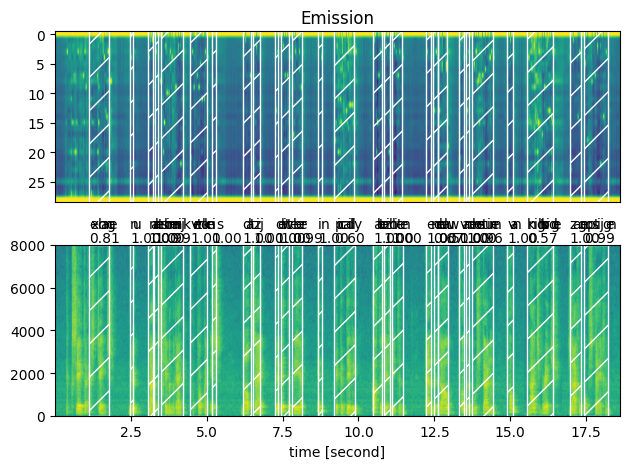

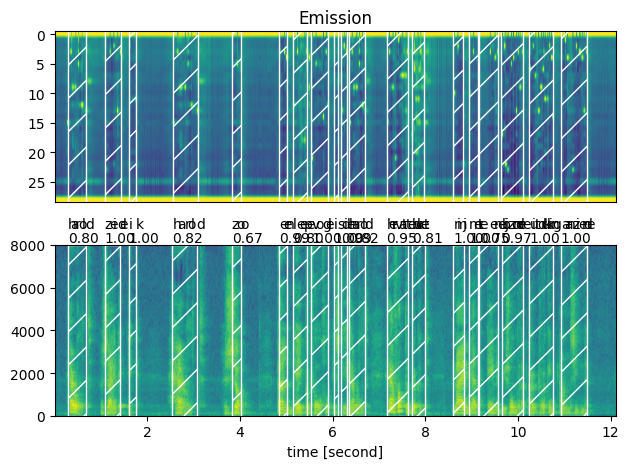

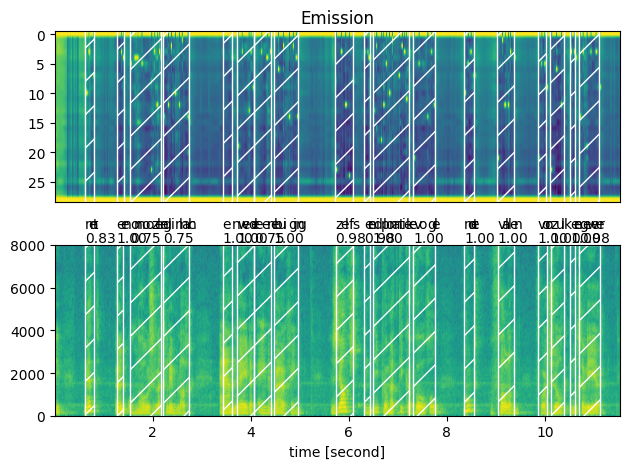

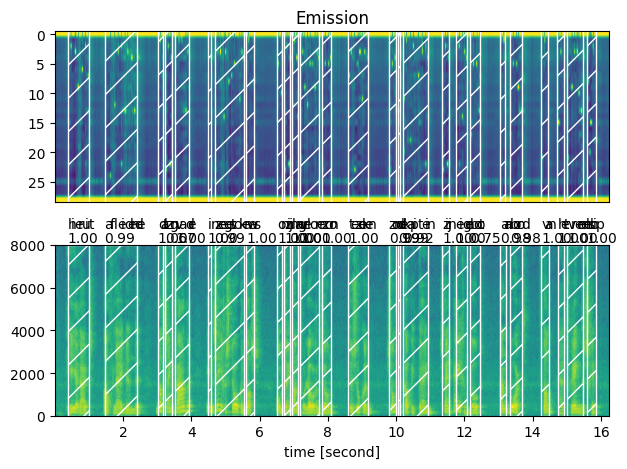

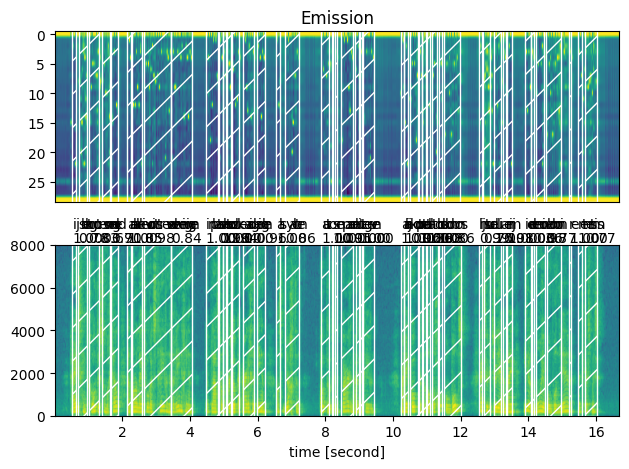

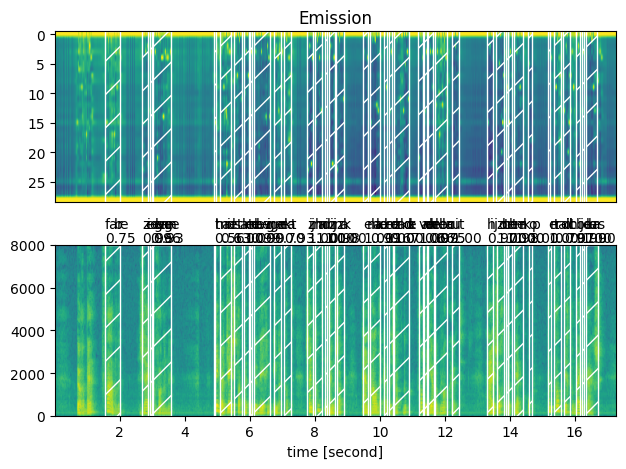

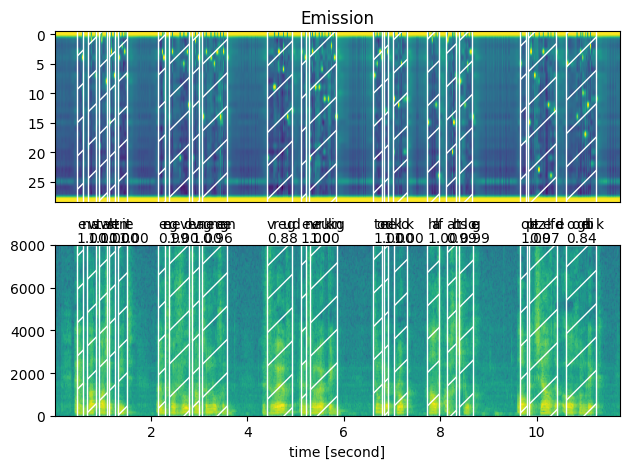

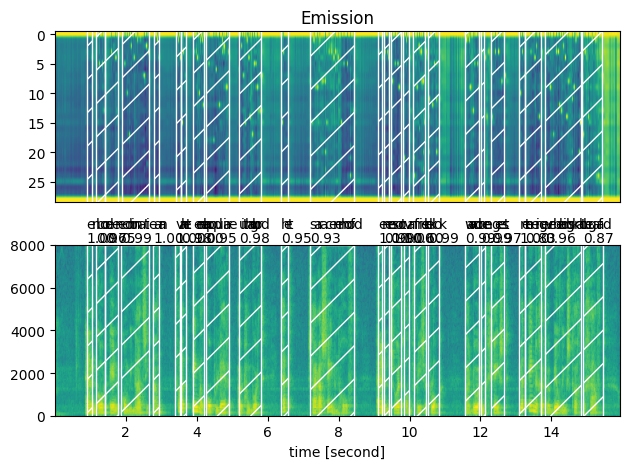

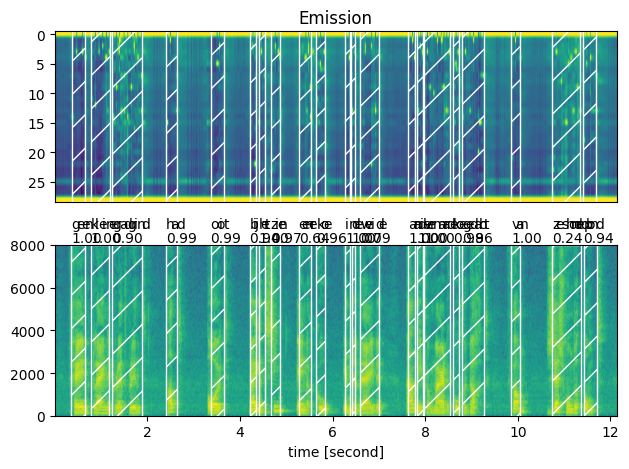

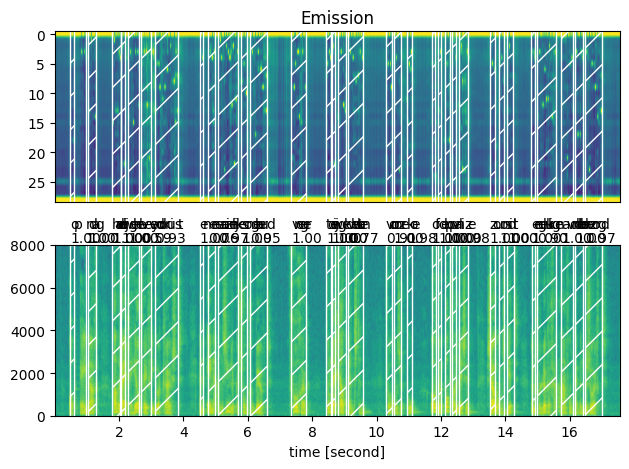

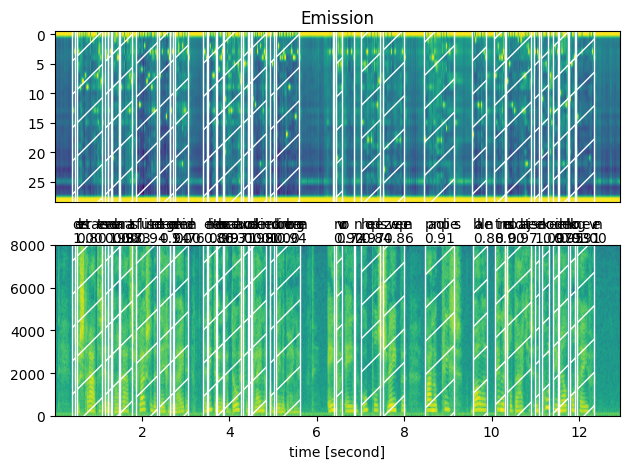

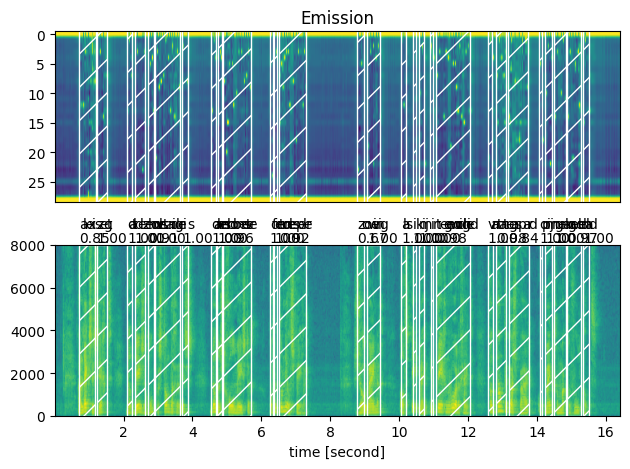

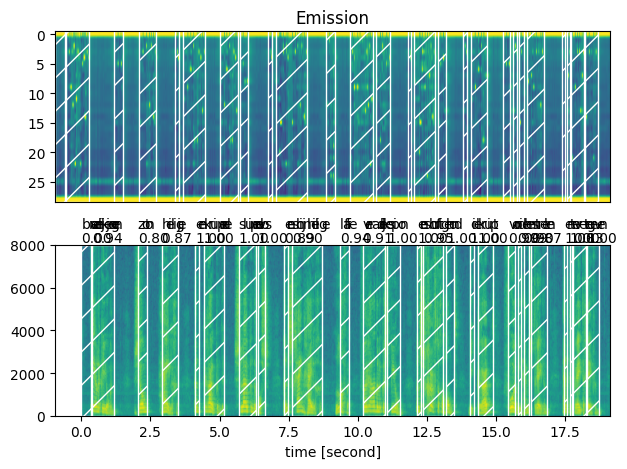

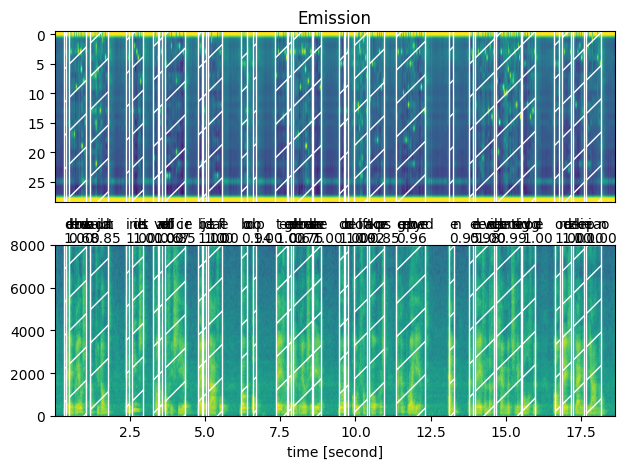

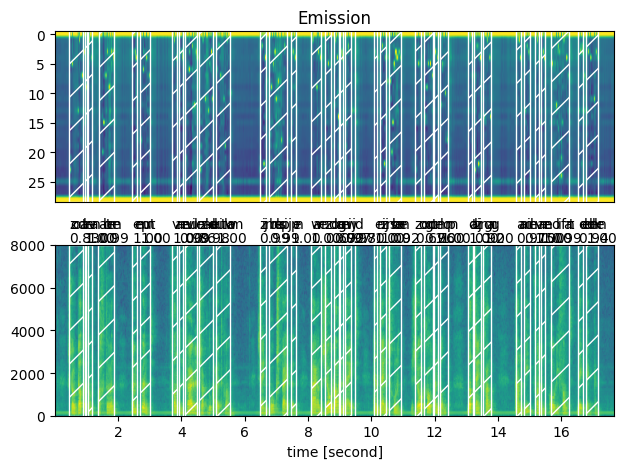

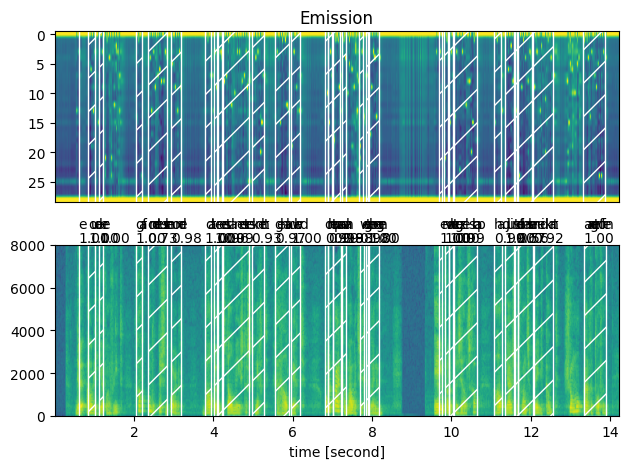

In [22]:
for datum in data:
    align1(datum)